In [ ]:
!nvidia-smi

Wed Mar 17 12:38:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.000642477days (55.51sec)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [2]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp "drive/My Drive/ImageNet/cortical_ImagenetTrain2.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [6]:
!unzip -nq "cortical_ImagenetTrain2.zip"
!unzip -nq "cortical_ImagenetTest2.zip"

In [7]:
def make_path_list(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list


In [8]:
rootpathTrain ='cortical_ImagenetTrain2/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [9]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [10]:
class ImageNetDataset(data.Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.label_name = [x.split("/")[1] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        #img, anno_class_img, label = self.pull_item(index)
        #return img, anno_class_img, label
        img, label = self.pull_item(index)
        return img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        #anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        #return img, anno_class_img, label
        return img, label

In [11]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [12]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [13]:
classes_list

['apple',
 'banana',
 'bear',
 'bell_pepper',
 'bird',
 'broccoli',
 'cat',
 'cauliflower',
 'cow',
 'dog',
 'elephant',
 'fox',
 'goat',
 'horse',
 'mashed_potato',
 'orange',
 'pineapple',
 'pomegranate',
 'tomato',
 'zebra']

In [14]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [15]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [16]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

14164

In [17]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


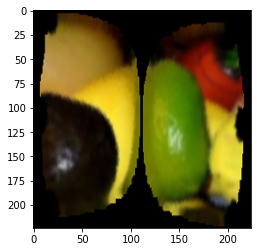

In [24]:
index = 1890
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [25]:
label

1

In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 100

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
LOAD_STATE = True
EPOCH = 100             # This values need to check the latest tar ffile name with epoch.
name = "04_3_mobilenet"

if LOAD_STATE:
    stats=[];
    folder_name = "mobilenet"
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    use_pretrained = True
    best_model = models.mobilenet_v2(pretrained=use_pretrained)
    best_model.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)
    best_model.cuda()
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "mobilenet", DEBUG)

Epoch 1/100
-------------



5625
train Loss: 0.0613 Acc: 39.7134



1605
val Loss: 0.0543 Acc: 45.3390
-------------
Epoch 2/100
-------------



7674
train Loss: 0.0454 Acc: 54.1796



1606
val Loss: 0.0553 Acc: 45.3672
-------------
Epoch 3/100
-------------



8467
train Loss: 0.0398 Acc: 59.7783



1886
val Loss: 0.0461 Acc: 53.2768
-------------
Epoch 4/100
-------------



9025
train Loss: 0.0357 Acc: 63.7179



1807
val Loss: 0.0490 Acc: 51.0452
-------------
Epoch 5/100
-------------



9401
train Loss: 0.0327 Acc: 66.3725



1971
val Loss: 0.0474 Acc: 55.6780
-------------
Epoch 6/100
-------------



9760
train Loss: 0.0302 Acc: 68.9071



2004
val Loss: 0.0456 Acc: 56.6102
-------------
Epoch 7/100
-------------



10116
train Loss: 0.0273 Acc: 71.4205



2043
val Loss: 0.0449 Acc: 57.7119
-------------
Epoch 8/100
-------------



10338
train Loss: 0.0258 Acc: 72.9879



1900
val Loss: 0.0487 Acc: 53.6723
-------------
Epoch 9/100
-------------



10557
train Loss: 0.0240 Acc: 74.5340



2024
val Loss: 0.0487 Acc: 57.1751
-------------
Epoch 10/100
-------------



10933
train Loss: 0.0221 Acc: 77.1886



2097
val Loss: 0.0472 Acc: 59.2373
-------------
Epoch 11/100
-------------



11067
train Loss: 0.0209 Acc: 78.1347



2077
val Loss: 0.0486 Acc: 58.6723
-------------
Epoch 12/100
-------------



11297
train Loss: 0.0193 Acc: 79.7585



1976
val Loss: 0.0508 Acc: 55.8192
-------------
Epoch 13/100
-------------



11485
train Loss: 0.0183 Acc: 81.0859



1858
val Loss: 0.0572 Acc: 52.4859
-------------
Epoch 14/100
-------------



11732
train Loss: 0.0163 Acc: 82.8297



2028
val Loss: 0.0499 Acc: 57.2881
-------------
Epoch 15/100
-------------



11763
train Loss: 0.0159 Acc: 83.0486



2048
val Loss: 0.0500 Acc: 57.8531
-------------
Epoch 16/100
-------------



11891
train Loss: 0.0148 Acc: 83.9523



2016
val Loss: 0.0573 Acc: 56.9492
-------------
Epoch 17/100
-------------



12087
train Loss: 0.0139 Acc: 85.3361



1860
val Loss: 0.0653 Acc: 52.5424
-------------
Epoch 18/100
-------------



12115
train Loss: 0.0133 Acc: 85.5337



1949
val Loss: 0.0621 Acc: 55.0565
-------------
Epoch 19/100
-------------



12266
train Loss: 0.0125 Acc: 86.5998



2036
val Loss: 0.0567 Acc: 57.5141
-------------
Epoch 20/100
-------------



12417
train Loss: 0.0116 Acc: 87.6659



2027
val Loss: 0.0575 Acc: 57.2599
-------------
Epoch 21/100
-------------



12593
train Loss: 0.0105 Acc: 88.9085



2059
val Loss: 0.0583 Acc: 58.1638
-------------
Epoch 22/100
-------------



12618
train Loss: 0.0104 Acc: 89.0850



2008
val Loss: 0.0592 Acc: 56.7232
-------------
Epoch 23/100
-------------



12710
train Loss: 0.0095 Acc: 89.7345



1974
val Loss: 0.0641 Acc: 55.7627
-------------
Epoch 24/100
-------------



12813
train Loss: 0.0086 Acc: 90.4617



1964
val Loss: 0.0674 Acc: 55.4802
-------------
Epoch 25/100
-------------



12755
train Loss: 0.0091 Acc: 90.0522



2043
val Loss: 0.0637 Acc: 57.7119
-------------
Epoch 26/100
-------------



12897
train Loss: 0.0085 Acc: 91.0548



2068
val Loss: 0.0611 Acc: 58.4181
-------------
Epoch 27/100
-------------



13034
train Loss: 0.0074 Acc: 92.0220



2089
val Loss: 0.0628 Acc: 59.0113
-------------
Epoch 28/100
-------------



13104
train Loss: 0.0070 Acc: 92.5162



2004
val Loss: 0.0668 Acc: 56.6102
-------------
Epoch 29/100
-------------



13105
train Loss: 0.0072 Acc: 92.5233



2032
val Loss: 0.0666 Acc: 57.4011
-------------
Epoch 30/100
-------------



13264
train Loss: 0.0062 Acc: 93.6459



2035
val Loss: 0.0638 Acc: 57.4859
-------------
Epoch 31/100
-------------



13393
train Loss: 0.0051 Acc: 94.5566



2132
val Loss: 0.0635 Acc: 60.2260
-------------
Epoch 32/100
-------------



13423
train Loss: 0.0050 Acc: 94.7684



1964
val Loss: 0.0782 Acc: 55.4802
-------------
Epoch 33/100
-------------



13353
train Loss: 0.0055 Acc: 94.2742



2029
val Loss: 0.0702 Acc: 57.3164
-------------
Epoch 34/100
-------------



13339
train Loss: 0.0055 Acc: 94.1754



1979
val Loss: 0.0737 Acc: 55.9040
-------------
Epoch 35/100
-------------



13419
train Loss: 0.0049 Acc: 94.7402



1981
val Loss: 0.0752 Acc: 55.9605
-------------
Epoch 36/100
-------------



13384
train Loss: 0.0051 Acc: 94.4931



2102
val Loss: 0.0722 Acc: 59.3785
-------------
Epoch 37/100
-------------



13457
train Loss: 0.0048 Acc: 95.0085



2014
val Loss: 0.0796 Acc: 56.8927
-------------
Epoch 38/100
-------------



13506
train Loss: 0.0044 Acc: 95.3544



2012
val Loss: 0.0753 Acc: 56.8362
-------------
Epoch 39/100
-------------



13423
train Loss: 0.0049 Acc: 94.7684



2070
val Loss: 0.0703 Acc: 58.4746
-------------
Epoch 40/100
-------------



13498
train Loss: 0.0045 Acc: 95.2979



2071
val Loss: 0.0709 Acc: 58.5028
-------------
Epoch 41/100
-------------



13593
train Loss: 0.0038 Acc: 95.9687



2026
val Loss: 0.0759 Acc: 57.2316
-------------
Epoch 42/100
-------------



13628
train Loss: 0.0036 Acc: 96.2158



2004
val Loss: 0.0775 Acc: 56.6102
-------------
Epoch 43/100
-------------



13559
train Loss: 0.0041 Acc: 95.7286



2065
val Loss: 0.0738 Acc: 58.3333
-------------
Epoch 44/100
-------------



13675
train Loss: 0.0030 Acc: 96.5476



2001
val Loss: 0.0788 Acc: 56.5254
-------------
Epoch 45/100
-------------



13645
train Loss: 0.0036 Acc: 96.3358



2041
val Loss: 0.0782 Acc: 57.6554
-------------
Epoch 46/100
-------------



13624
train Loss: 0.0035 Acc: 96.1875



1996
val Loss: 0.0725 Acc: 56.3842
-------------
Epoch 47/100
-------------



13692
train Loss: 0.0030 Acc: 96.6676



2073
val Loss: 0.0738 Acc: 58.5593
-------------
Epoch 48/100
-------------



13711
train Loss: 0.0032 Acc: 96.8018



2063
val Loss: 0.0773 Acc: 58.2768
-------------
Epoch 49/100
-------------



13742
train Loss: 0.0028 Acc: 97.0206



2030
val Loss: 0.0767 Acc: 57.3446
-------------
Epoch 50/100
-------------



13757
train Loss: 0.0028 Acc: 97.1265



2080
val Loss: 0.0782 Acc: 58.7571
-------------
Epoch 51/100
-------------



13829
train Loss: 0.0022 Acc: 97.6348



2038
val Loss: 0.0866 Acc: 57.5706
-------------
Epoch 52/100
-------------



13728
train Loss: 0.0029 Acc: 96.9218



2018
val Loss: 0.0826 Acc: 57.0056
-------------
Epoch 53/100
-------------



13808
train Loss: 0.0025 Acc: 97.4866



2029
val Loss: 0.0804 Acc: 57.3164
-------------
Epoch 54/100
-------------



13800
train Loss: 0.0024 Acc: 97.4301



2056
val Loss: 0.0828 Acc: 58.0791
-------------
Epoch 55/100
-------------



13876
train Loss: 0.0020 Acc: 97.9667



2075
val Loss: 0.0799 Acc: 58.6158
-------------
Epoch 56/100
-------------



13930
train Loss: 0.0017 Acc: 98.3479



2071
val Loss: 0.0805 Acc: 58.5028
-------------
Epoch 57/100
-------------



13849
train Loss: 0.0021 Acc: 97.7761



2032
val Loss: 0.0836 Acc: 57.4011
-------------
Epoch 58/100
-------------



13793
train Loss: 0.0025 Acc: 97.3807



2048
val Loss: 0.0805 Acc: 57.8531
-------------
Epoch 59/100
-------------



13884
train Loss: 0.0019 Acc: 98.0232



2084
val Loss: 0.0815 Acc: 58.8701
-------------
Epoch 60/100
-------------



13958
train Loss: 0.0014 Acc: 98.5456



2109
val Loss: 0.0817 Acc: 59.5763
-------------
Epoch 61/100
-------------



13863
train Loss: 0.0019 Acc: 97.8749



2035
val Loss: 0.0874 Acc: 57.4859
-------------
Epoch 62/100
-------------



13880
train Loss: 0.0018 Acc: 97.9949



2076
val Loss: 0.0822 Acc: 58.6441
-------------
Epoch 63/100
-------------



13933
train Loss: 0.0015 Acc: 98.3691



2088
val Loss: 0.0825 Acc: 58.9831
-------------
Epoch 64/100
-------------



13926
train Loss: 0.0016 Acc: 98.3197



2107
val Loss: 0.0863 Acc: 59.5198
-------------
Epoch 65/100
-------------



13860
train Loss: 0.0021 Acc: 97.8537



2055
val Loss: 0.0836 Acc: 58.0508
-------------
Epoch 66/100
-------------



13842
train Loss: 0.0022 Acc: 97.7266



2101
val Loss: 0.0799 Acc: 59.3503
-------------
Epoch 67/100
-------------



13921
train Loss: 0.0016 Acc: 98.2844



2077
val Loss: 0.0855 Acc: 58.6723
-------------
Epoch 68/100
-------------



13894
train Loss: 0.0017 Acc: 98.0938



2070
val Loss: 0.0851 Acc: 58.4746
-------------
Epoch 69/100
-------------



13872
train Loss: 0.0020 Acc: 97.9384



2106
val Loss: 0.0826 Acc: 59.4915
-------------
Epoch 70/100
-------------



13913
train Loss: 0.0016 Acc: 98.2279



2063
val Loss: 0.0861 Acc: 58.2768
-------------
Epoch 71/100
-------------



13930
train Loss: 0.0016 Acc: 98.3479



2066
val Loss: 0.0838 Acc: 58.3616
-------------
Epoch 72/100
-------------



13916
train Loss: 0.0016 Acc: 98.2491



2097
val Loss: 0.0812 Acc: 59.2373
-------------
Epoch 73/100
-------------



14022
train Loss: 0.0009 Acc: 98.9975



2047
val Loss: 0.0872 Acc: 57.8249
-------------
Epoch 74/100
-------------



13946
train Loss: 0.0014 Acc: 98.4609



2080
val Loss: 0.0877 Acc: 58.7571
-------------
Epoch 75/100
-------------



13912
train Loss: 0.0016 Acc: 98.2208



1991
val Loss: 0.0872 Acc: 56.2429
-------------
Epoch 76/100
-------------



13850
train Loss: 0.0021 Acc: 97.7831



2119
val Loss: 0.0824 Acc: 59.8588
-------------
Epoch 77/100
-------------



13908
train Loss: 0.0018 Acc: 98.1926



2044
val Loss: 0.0838 Acc: 57.7401
-------------
Epoch 78/100
-------------



13897
train Loss: 0.0018 Acc: 98.1149



2079
val Loss: 0.0801 Acc: 58.7288
-------------
Epoch 79/100
-------------



14026
train Loss: 0.0009 Acc: 99.0257



2117
val Loss: 0.0827 Acc: 59.8023
-------------
Epoch 80/100
-------------



14069
train Loss: 0.0007 Acc: 99.3293



2057
val Loss: 0.0919 Acc: 58.1073
-------------
Epoch 81/100
-------------



13931
train Loss: 0.0016 Acc: 98.3550



2079
val Loss: 0.0881 Acc: 58.7288
-------------
Epoch 82/100
-------------



13999
train Loss: 0.0011 Acc: 98.8351



2093
val Loss: 0.0886 Acc: 59.1243
-------------
Epoch 83/100
-------------



14020
train Loss: 0.0010 Acc: 98.9833



2014
val Loss: 0.0925 Acc: 56.8927
-------------
Epoch 84/100
-------------



13985
train Loss: 0.0012 Acc: 98.7362



2010
val Loss: 0.0963 Acc: 56.7797
-------------
Epoch 85/100
-------------



13995
train Loss: 0.0012 Acc: 98.8068



2091
val Loss: 0.0873 Acc: 59.0678
-------------
Epoch 86/100
-------------



14034
train Loss: 0.0009 Acc: 99.0822



2029
val Loss: 0.0944 Acc: 57.3164
-------------
Epoch 87/100
-------------



13990
train Loss: 0.0012 Acc: 98.7715



2110
val Loss: 0.0897 Acc: 59.6045
-------------
Epoch 88/100
-------------



14053
train Loss: 0.0008 Acc: 99.2163



2117
val Loss: 0.0933 Acc: 59.8023
-------------
Epoch 89/100
-------------



14072
train Loss: 0.0006 Acc: 99.3505



2105
val Loss: 0.0964 Acc: 59.4633
-------------
Epoch 90/100
-------------



14030
train Loss: 0.0009 Acc: 99.0539



2027
val Loss: 0.0970 Acc: 57.2599
-------------
Epoch 91/100
-------------



14004
train Loss: 0.0011 Acc: 98.8704



2005
val Loss: 0.0967 Acc: 56.6384
-------------
Epoch 92/100
-------------



13957
train Loss: 0.0015 Acc: 98.5385



2070
val Loss: 0.0916 Acc: 58.4746
-------------
Epoch 93/100
-------------



13977
train Loss: 0.0012 Acc: 98.6798



2060
val Loss: 0.0914 Acc: 58.1921
-------------
Epoch 94/100
-------------



14046
train Loss: 0.0008 Acc: 99.1669



2101
val Loss: 0.0883 Acc: 59.3503
-------------
Epoch 95/100
-------------



14071
train Loss: 0.0006 Acc: 99.3434



2047
val Loss: 0.0958 Acc: 57.8249
-------------
Epoch 96/100
-------------



14051
train Loss: 0.0007 Acc: 99.2022



2091
val Loss: 0.0969 Acc: 59.0678
-------------
Epoch 97/100
-------------



13972
train Loss: 0.0013 Acc: 98.6445



2079
val Loss: 0.0875 Acc: 58.7288
-------------
Epoch 98/100
-------------



13971
train Loss: 0.0013 Acc: 98.6374



2059
val Loss: 0.0938 Acc: 58.1638
-------------
Epoch 99/100
-------------



14054
train Loss: 0.0008 Acc: 99.2234



2098
val Loss: 0.0897 Acc: 59.2655
-------------
Epoch 100/100
-------------



14076
train Loss: 0.0006 Acc: 99.3787



2053
val Loss: 0.0948 Acc: 57.9944
-------------
Lowest training loss 0.0005747967023483496
Lowest validation loss 0.04486767060339114
Highest training accuracy 99.37870658006213
Highest validation accuracy 60.22598870056497
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/simple/{name}.pth"
torch.save(best_model.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/04_3_mobilenet_Loss _.png04_3_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_3_mobilenet_Accuracy _.png04_3_mobilenet_Accuracy _.png


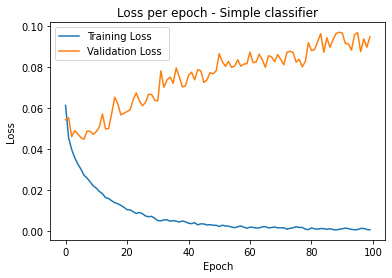

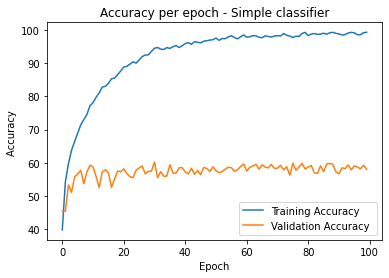

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.2285 
Testing Accuracy: 1143/2000 (57.15%)
apple Class Accuracy: 53/100 (53.00%)
banana Class Accuracy: 60/100 (60.00%)
bear Class Accuracy: 71/100 (71.00%)
bell_pepper Class Accuracy: 61/100 (61.00%)
bird Class Accuracy: 48/100 (48.00%)
broccoli Class Accuracy: 70/100 (70.00%)
cat Class Accuracy: 39/100 (39.00%)
cauliflower Class Accuracy: 49/100 (49.00%)
cow Class Accuracy: 29/100 (29.00%)
dog Class Accuracy: 41/100 (41.00%)
elephant Class Accuracy: 63/100 (63.00%)
fox Class Accuracy: 63/100 (63.00%)
goat Class Accuracy: 29/100 (29.00%)
horse Class Accuracy: 46/100 (46.00%)
mashed_potato Class Accuracy: 62/100 (62.00%)
orange Class Accuracy: 73/100 (73.00%)
pineapple Class Accuracy: 63/100 (63.00%)
pomegranate Class Accuracy: 73/100 (73.00%)
tomato Class Accuracy: 66/100 (66.00%)
zebra Class Accuracy: 84/100 (84.00%)
Classifier has Acc=0.572 P=0.572 R=0.579 F1=0.569
               precision    recall  f1-score   support

        apple       0.67      0.53      0.59     

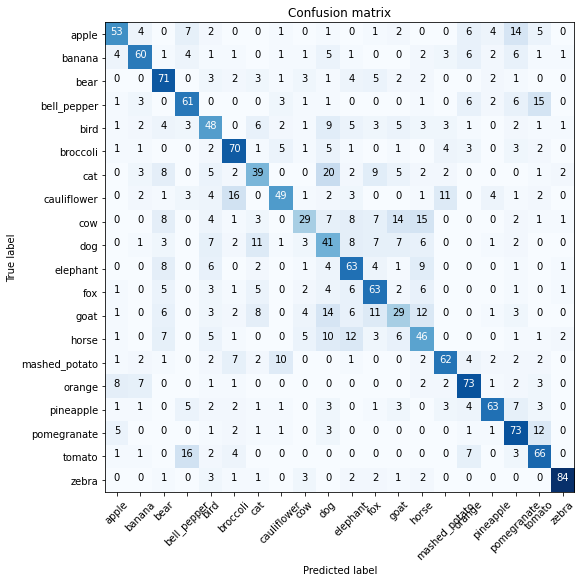

In [ ]:
result = test_model(best_model, criterion, name)